In [1]:
import pandas as pd
import numpy as np
import googlemaps
from datetime import datetime
import acquire_r
from env import google_key, google_key1
from googlemaps import convert
import wrangle_zillow_r
import wrangle_zillow
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import gmaps
import gmaps.datasets
gmaps.configure(api_key=google_key1) # Fill in with your API key
%matplotlib inline

In [2]:
#df = acquire_r.get_zillow_data()
# df1 = df1.dropna()

In [3]:
#df.to_csv('zillow.csv')

In [4]:
zillow = pd.read_csv('zillow.csv')

In [5]:
single_use = [261, 262, 263, 264, 266, 268, 273, 276, 279]
zillow = zillow[zillow.propertylandusetypeid.isin(single_use)]

In [6]:
zillow = zillow[(zillow.bedroomcnt > 0) & (zillow.bathroomcnt > 0) & ((df.unitcnt<=1)|df.unitcnt.isnull())]

NameError: name 'df' is not defined

In [7]:
zillow.unitcnt.value_counts()

1.0    45403
2.0       34
3.0        3
6.0        1
Name: unitcnt, dtype: int64

In [8]:
zillow.fips.value_counts()

6037.0    45672
6059.0    20405
6111.0     5783
Name: fips, dtype: int64

In [9]:
zillow['county'] = np.where(zillow.fips == 6037, 'Los_Angeles',
                            np.where(zillow.fips == 6059, 'Orange', 'Ventura'))

In [10]:
zillow['regionidzip'] = zillow['regionidzip'].replace(399675, 99675)

In [11]:
zillow = wrangle_zillow_r.zillow_impute_knn(zillow)

In [12]:
zillow = wrangle_zillow_r.add_zip_income(zillow)

In [13]:
def fill_nulls_with_zero(df, col_names):
    for col in col_names:
        df[col] = df[col].fillna(0)
    return df

In [14]:
# Test function
null_cols = ['airconditioningtypeid', 'basementsqft', 'decktypeid',
             'fireplacecnt', 'garagecarcnt', 'garagetotalsqft',
             'hashottuborspa', 'lotsizesquarefeet', 'poolcnt',
             'poolsizesum', 'taxdelinquencyyear']

zillow = fill_nulls_with_zero(zillow, null_cols)

In [15]:
# Heatingorsystemtypeid - None type is 13
# Assume number of stories is 1
# Assume unitcnt is 1

def handle_other_nulls(df):
    df.heatingorsystemtypeid.fillna(13, inplace=True)
    df.numberofstories.fillna(1, inplace=True)
    df.unitcnt.fillna(1, inplace=True)
    return df

In [16]:
zillow = handle_other_nulls(zillow)

In [17]:
zillow.isnull().sum().sort_values(ascending = False)

buildingclasstypeid     74234
buildingclassdesc       74234
finishedsquarefeet13    74232
finishedsquarefeet15    74223
storydesc               74187
                        ...  
poolsizesum                 0
poolcnt                     0
lotsizesquarefeet           0
longitude                   0
Unnamed: 0                  0
Length: 73, dtype: int64

In [18]:
zillow = wrangle_zillow.remove_columns(zillow, 
                                       ['parcelid',
                                        'architecturalstyletypeid',
                                        'buildingclasstypeid',
                                        'finishedsquarefeet13',
                                        'finishedsquarefeet15',
                                        'finishedsquarefeet50',
                                        'finishedsquarefeet6',
                                        'finishedfloor1squarefeet',
                                        'pooltypeid10',
                                        'pooltypeid2',
                                        'pooltypeid7',
                                        'fireplaceflag',
                                        'airconditioningdesc',
                                        'storydesc',
                                        'heatingorsystemdesc',
                                        'architecturalstyledesc',
                                        'buildingclassdesc',
                                        'typeconstructiondesc',
                                        'yardbuildingsqft17',
                                        'yardbuildingsqft26',
                                        'calculatedbathnbr',
                                        'fullbathcnt',
                                        'threequarterbathnbr',
                                        'typeconstructiontypeid',
                                        'storytypeid',
                                        'propertyzoningdesc', 
                                        'calculatedfinishedsquarefeet', 
                                        'regionidneighborhood',
                                        'regionidcity',
                                        'regionidcounty',
                                        'propertylandusetypeid',
                                        'rawcensustractandblock',
                                        'propertylandusedesc',
                                        'assessmentyear'])

In [19]:
zillow.isnull().sum().sort_values(ascending = False)

taxdelinquencyflag            71436
buildingqualitytypeid         27478
finishedsquarefeet12            349
yearbuilt                       219
structuretaxvaluedollarcnt      122
taxamount                         5
landtaxvaluedollarcnt             2
taxvaluedollarcnt                 1
hashottuborspa                    0
garagetotalsqft                   0
garagecarcnt                      0
fireplacecnt                      0
fips                              0
median_income                     0
latitude                          0
decktypeid                        0
bedroomcnt                        0
bathroomcnt                       0
basementsqft                      0
airconditioningtypeid             0
id                                0
heatingorsystemtypeid             0
poolsizesum                       0
longitude                         0
lotsizesquarefeet                 0
poolcnt                           0
new_zip                           0
propertycountylandusecode   

In [20]:
zillow = zillow.drop(columns = ['taxdelinquencyflag', 'buildingqualitytypeid'])

In [21]:

def zillow_imputer(df):
    num_vars = list(df.select_dtypes('number').columns)
    imp = IterativeImputer(random_state=423)
    imp.fit(df[num_vars])
    df[num_vars] = imp.transform(df[num_vars])
    return df

In [22]:
zillow = zillow_imputer(zillow)

In [5]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64840 entries, 0 to 73751
Data columns (total 37 columns):
Unnamed: 0                    64840 non-null float64
airconditioningtypeid         64840 non-null object
basementsqft                  64840 non-null int64
bathroomcnt                   64840 non-null int64
bedroomcnt                    64840 non-null int64
buildingqualitytypeid         64840 non-null object
decktypeid                    64840 non-null object
finishedsquarefeet12          64840 non-null int64
fireplacecnt                  64840 non-null int64
garagecarcnt                  64840 non-null int64
garagetotalsqft               64840 non-null int64
hashottuborspa                64840 non-null int64
heatingorsystemtypeid         64840 non-null object
latitude                      64840 non-null float64
longitude                     64840 non-null float64
lotsizesquarefeet             64840 non-null int64
poolcnt                       64840 non-null int64
poolsizesum   

In [43]:
zillow

,Unnamed: 0,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,decktypeid,finishedsquarefeet12,fireplacecnt,garagecarcnt,...,taxdelinquencyflag,taxdelinquencyyear,logerror,transactiondate,haversine_distance,regionid_zip,census_tractandblock,new_zip,median_income,county
0,0.0,0,0,2,3,8,0,2107,0,0,...,0,0,-0.007357,2017-07-07,87.506921,96339.0,6.03711e+13,91304.0,"66,044",Los_Angeles
1,1.0,1,0,2,4,8,0,1882,0,0,...,0,0,0.021066,2017-08-29,87.601806,96339.0,6.03711e+13,91304.0,"66,044",Los_Angeles
2,2.0,1,0,2,4,8,0,1882,0,0,...,0,0,0.077174,2017-04-04,87.474112,96339.0,6.03711e+13,91304.0,"66,044",Los_Angeles
3,3.0,0,0,2,3,8,0,1477,0,0,...,0,0,-0.041238,2017-03-17,87.440105,96339.0,6.03711e+13,91304.0,"66,044",Los_Angeles
4,4.0,0,0,2,4,8,0,1918,0,0,...,0,0,-0.009496,2017-03-24,87.494754,96339.0,6.03711e+13,91304.0,"66,044",Los_Angeles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73742,77558.0,0,0,3,3,4,0,1850,0,0,...,0,0,0.063190,2017-07-11,104.345462,97047.0,6.03711e+13,92840.0,"62,196",Los_Angeles
73744,77560.0,0,0,1,2,7,0,756,0,0,...,0,0,-0.217256,2017-01-19,106.100377,96229.0,6.03711e+13,90745.0,"68,058",Los_Angeles
73746,77565.0,1,0,3,3,4,0,2108,0,0,...,0,0,-0.158701,2017-06-14,73.622987,96395.0,6.03711e+13,91381.0,"108,993",Los_Angeles
73748,77567.0,1,0,2,2,4,0,1480,0,0,...,0,0,-0.009925,2017-01-31,69.199412,96513.0,6.03711e+13,91773.0,"76,397",Los_Angeles


In [105]:
zillow = wrangle_zillow.wrangle_zillow()

In [106]:
zillow = zillow.dropna()

In [112]:
zillow['median_income'] = zillow.median_income.str.strip()

In [113]:
zillow['median_income'] = zillow.median_income.str.replace(',', '').astype(float)

In [114]:
zillow.median_income

0         66044.0
1         66044.0
2         66044.0
3         66044.0
4         66044.0
           ...   
73742     62196.0
73744     68058.0
73746    108993.0
73748     76397.0
73751     53646.0
Name: median_income, Length: 64833, dtype: float64

In [67]:
#random state 539

In [131]:
train, test = train_test_split(zillow, train_size = .80, random_state = 539)

In [132]:
train, validate = train_test_split(train, train_size = .80, random_state = 539)

### cluster the traget variable (logerror)

In [133]:
def cluster(train, X, k):
    scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
    kmeans = KMeans(n_clusters = k, random_state = 539)
    kmeans.fit(X_scaled)
    kmeans.predict(X_scaled)
    train['cluster'] = kmeans.predict(X_scaled)
    train['cluster'] = 'cluster_' + train.cluster.astype(str)
    return train, X_scaled, scaler, kmeans

def scatter_plot(x,y,train,kmeans, X_scaled, scaler):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x = x, y = y, data = train, hue = 'cluster')
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    centroids.plot.scatter(y=y, x= x, ax=plt.gca(), alpha=.30, s=500, c='black')

In [7]:
X = train[['logerror']]

In [8]:
scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
kmeans = KMeans(n_clusters = 5, random_state=539)
kmeans.fit(X_scaled)
kmeans.predict(X_scaled)
train['cluster'] = kmeans.predict(X_scaled)
train['cluster'] = 'cluster_' + train.cluster.astype(str)


In [9]:
locations = train[train.cluster == 'cluster_3'][['latitude', 'longitude']]
weights = train[train.cluster == 'cluster_3']['logerror']
fig = gmaps.figure()
fig.add_layer(gmaps.symbol_layer(locations/1000000, fill_color='red', stroke_color='red', scale=2))
fig
#plt.figure(figsize=(10, 6))
#sns.scatterplot(x = 'latitude', y = 'longitude', data = train[train.cluster =='cluster_1'], hue = 'cluster')
#gmaps.figure(center=(34.069091, -118.284055), zoom_level=12)

# fig.add_layer(gmaps.heatmap_layer(locations/1000000, weights = weights))
# gmaps.figure(center=(34.069091, -118.284055), zoom_level=12)


Figure(layout=FigureLayout(height='420px'))

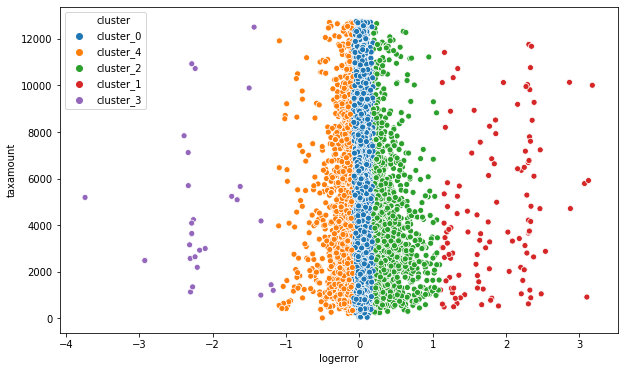

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'taxamount', data = train, hue = 'cluster')

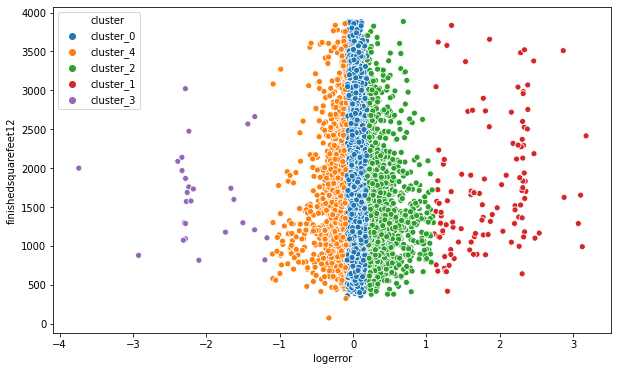

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'finishedsquarefeet12', data = train, hue = 'cluster')


(90000.0, 94000.0)

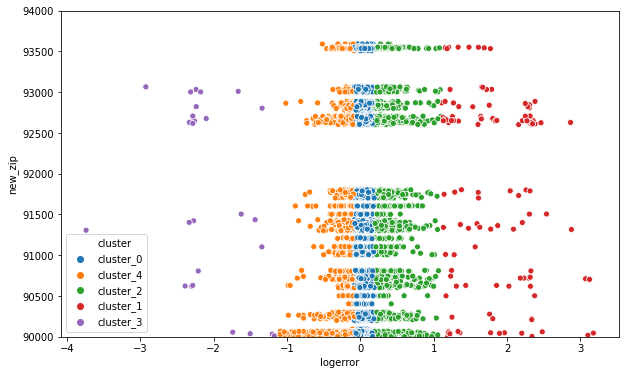

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'new_zip', data = train, hue = 'cluster')
plt.ylim(90000, 94000)

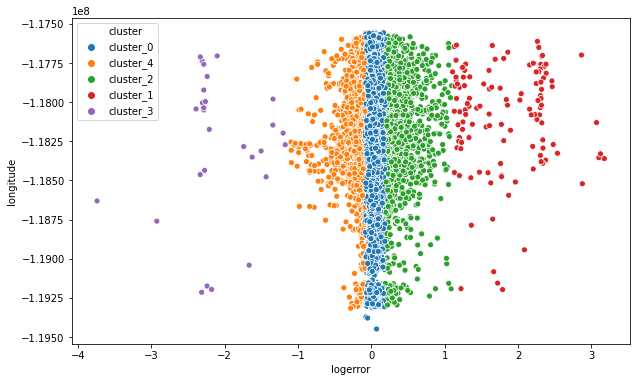

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'longitude', data = train, hue = 'cluster')

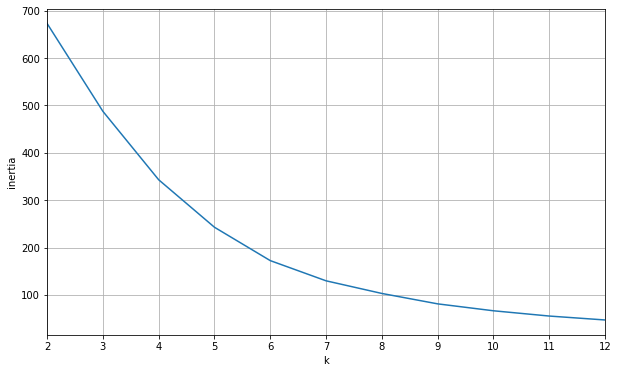

In [14]:
def get_inertia(k):
    kmeans = KMeans(k)
    kmeans.fit(X)
    return kmeans.inertia_

plt.figure(figsize=(10, 6))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

### Cluster Independent Variables

Location, that is, latitude and longitude\
Size (finished square feet)\
Location and size\
Be sure to use these new clusters in exploring your data, and interpret what these clusters tell you.

In [15]:
train = train.drop(columns = 'cluster')

In [16]:
X = train[['latitude', 'longitude']]

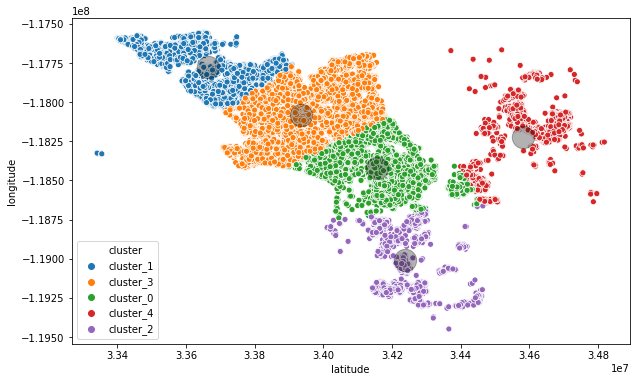

In [17]:
train, X_scaled, scaler, kmeans = cluster(train, X, 5)
scatter_plot('latitude','longitude',train,kmeans, X_scaled, scaler)

In [36]:
heatmap_layer.max_intensity = 4
heatmap_layer.point_radius = 5


In [29]:
locations = train[['latitude', 'longitude']]
weights = train['logerror']
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(locations/1000000, weights = abs(weights))
fig.add_layer(heatmap_layer)
#fig.add_layer(gmaps.symbol_layer(locations/1000000, fill_color='red', stroke_color='red', scale=2))
fig

Figure(layout=FigureLayout(height='420px'))

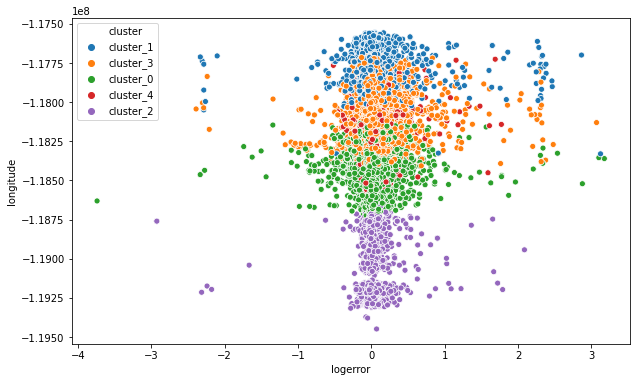

In [18]:
#scatter_plot('logerror','longitude',train,kmeans, X_scaled, scaler)
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'longitude', data = train, hue = 'cluster')

(-1.0, 1.0)

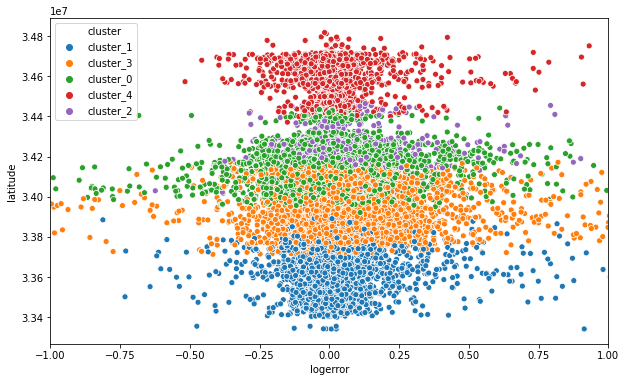

In [90]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'latitude', data = train, hue = 'cluster')
plt.xlim(-1,1)

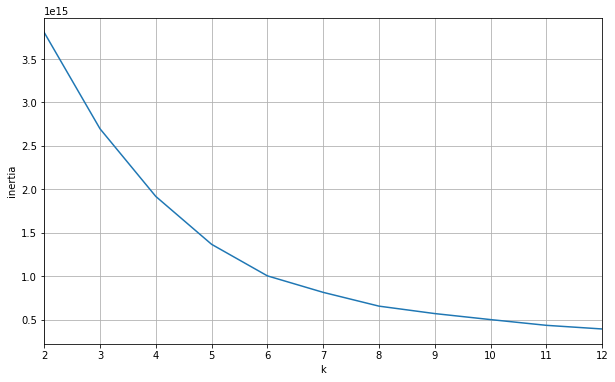

In [21]:
def get_inertia(k):
    kmeans = KMeans(k)
    kmeans.fit(X)
    return kmeans.inertia_

plt.figure(figsize=(10, 6))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

In [22]:
# lets cluster based on size (sqft)
X = train[['finishedsquarefeet12','logerror']]

(-1.0, 1.0)

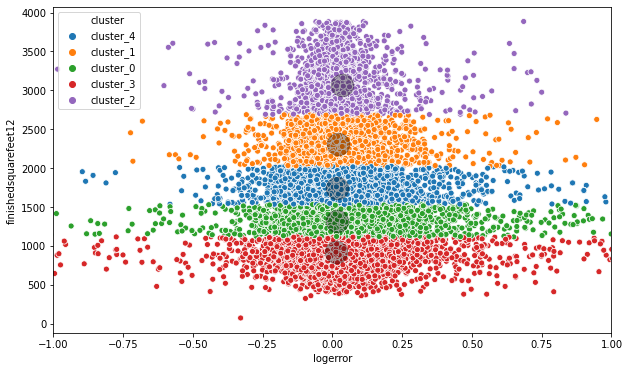

In [23]:
train, X_scaled, scaler, kmeans = cluster(train, X, 5)
scatter_plot('logerror','finishedsquarefeet12',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)

In [24]:
X = train[['latitude', 'longitude', 'finishedsquarefeet12', 'logerror']]

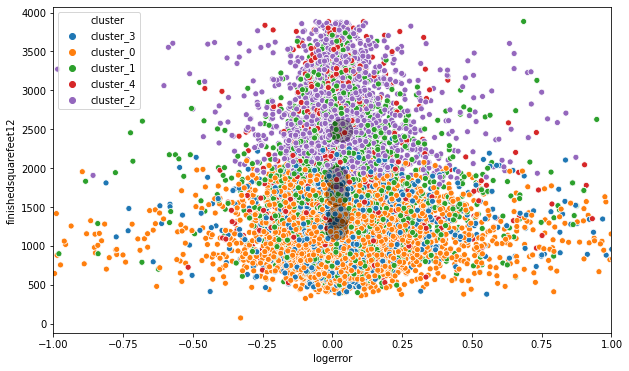

In [25]:
train, X_scaled, scaler, kmeans = cluster(train, X, 5)
scatter_plot('logerror','finishedsquarefeet12',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

(-1.0, 1.0)

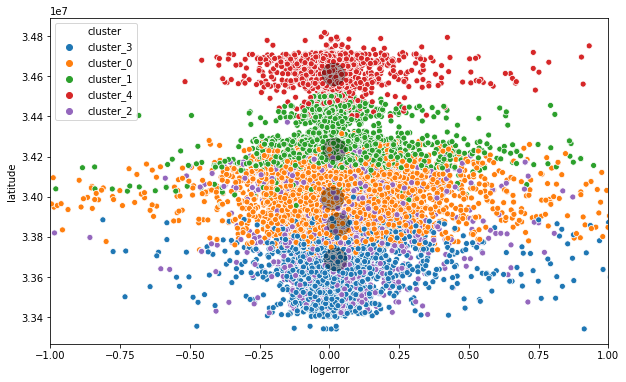

In [26]:
scatter_plot('logerror','latitude',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)

(-1.0, 1.0)

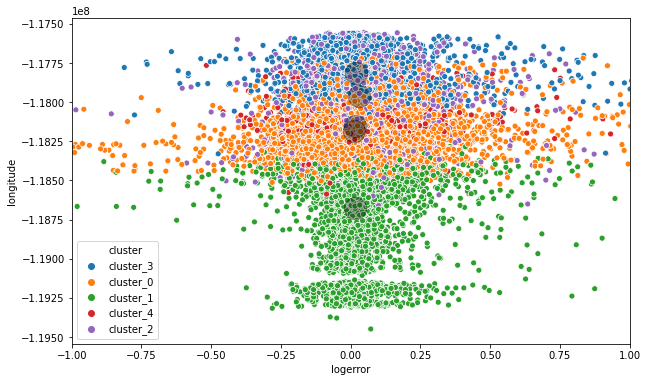

In [27]:
scatter_plot('logerror','longitude',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)

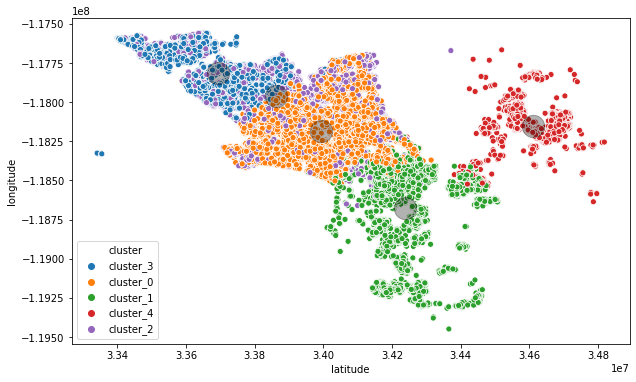

In [28]:
scatter_plot('latitude','longitude',train,kmeans, X_scaled, scaler)

In [201]:
X = train[['taxvaluedollarcnt', 'median_income','finishedsquarefeet12']]

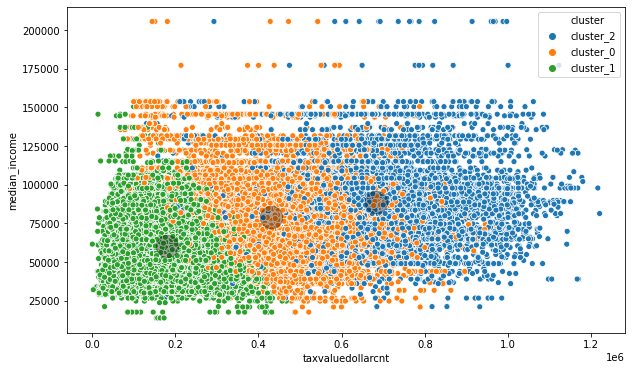

In [220]:
train, X_scaled, scaler, kmeans = cluster(train, X, 3)
scatter_plot('taxvaluedollarcnt','median_income',train,kmeans, X_scaled, scaler)
#plt.xlim(-1,1)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

In [221]:
centroids['ratio'] = centroids.median_income/centroids.taxvaluedollarcnt
centroids

,taxvaluedollarcnt,median_income,finishedsquarefeet12,ratio
0,431144.322728,78934.505805,1530.445635,0.183081
1,180743.393002,60440.017310,1267.661301,0.334397
2,683640.331176,88817.894162,2454.960598,0.129919


In [222]:
train[train.cluster == 'cluster_0'].logerror.mean()

0.009808542392645751

In [223]:
train[train.cluster == 'cluster_1'].logerror.mean()

0.015367188618411189

In [224]:
train[train.cluster == 'cluster_2'].logerror.mean()

0.020785911308976092

In [208]:
train[train.cluster == 'cluster_3'].logerror.mean()

0.008220001898746814

In [150]:
train[train.cluster == 'cluster_4'].logerror.mean()

0.010615003983084846

In [215]:
x1 = train[train.cluster == 'cluster_0'].logerror
x2 = train[train.cluster == 'cluster_1'].logerror
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-3.283869401794108, pvalue=0.0010249417663841303)

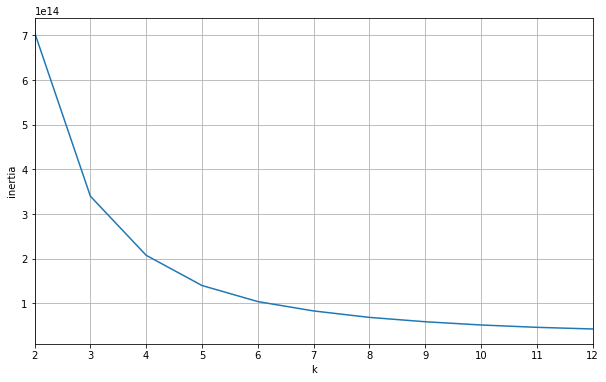

In [225]:
def get_inertia(k):
    kmeans = KMeans(k)
    kmeans.fit(X)
    return kmeans.inertia_

plt.figure(figsize=(10, 6))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

In [ ]:
train, X_scaled, scaler, kmeans = cluster(train, X, 5)
scatter_plot('taxamount','median_income',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)

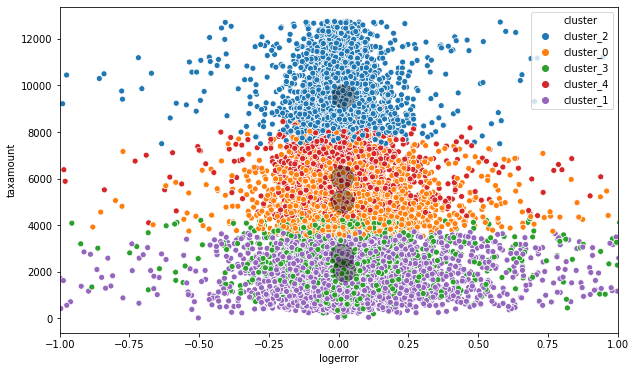

In [125]:
train, X_scaled, scaler, kmeans = cluster(train, X, 5)
scatter_plot('logerror','taxamount',train,kmeans, X_scaled, scaler)
plt.xlim(-1,1)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)